In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from openai import OpenAI

## Load Learned Codes

In [2]:
model_files = {
    'Dictator': 'records/system_prompts_Dictator.csv',
    'Proposer': 'records/system_prompts_Proposer.csv',
    'Responder': 'records/system_prompts_Responder.csv',
    'Investor': 'records/system_prompts_Investor.csv',
    'Banker': 'records/system_prompts_Banker.csv',
    'Public Goods': 'records/system_prompts_Public Goods.csv',
    'Bomb': 'records/system_prompts_Bomb.csv',
}

In [3]:
dfs = []
for game, model_file in model_files.items():
    df = pd.read_csv(model_file)
    # df = df[df['weight'] > 1e-3]
    df['game'] = game
    dfs.append(df)
df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)
df

,prompt,choices,desired_behavior,game
0,You are a purely self-interested player who al...,"[0, 1, 0, 0, 0, 1, 1, 0, 1, 1]",0,Dictator
1,You are motivated by maximizing your own gain ...,"[0, 10, 0, 0, 0, 1, 0, 0, 0, 0]",0,Dictator
2,You are a strategic decision-maker who always ...,"[1, 10, 10, 10, 1, 1, 0, 1, 1, 1]",0,Dictator
3,You are an uncompromising negotiator who prior...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,Dictator
4,You are a strategic decision-maker in competit...,"[1, 10, 1, 10, 10, 5, 1, 10, 0, 1]",0,Dictator
...,...,...,...,...
10691,You are an expert in maximizing outcomes by fo...,"[50, 50, 50, 50, 51, 50, 50, 50, 50, 50]",99,Bomb
10692,You are a highly strategic thinker who always ...,"[50, 50, 50, 50, 50, 50, 50, 50, 50, 50]",100,Bomb
10693,You are an intrepid decision-maker driven by t...,"[100, 100, 100, 100, 100, 99, 99, 99, 100, 100]",100,Bomb
10694,You are a risk-taking decision-maker who alway...,"[99, 100, 100, 100, 100, 100, 100, 100, 100, 100]",100,Bomb


## Text Processing

### Tokenization

Skip the below cell if you want to examine the processed data (`records/system_prompts_all.csv`).

In [ ]:
# import spacy

# nlp = spacy.load("en_core_web_sm")

# def tokenize(text):
#     doc = nlp(text)
#     res = " ".join([token.lemma_ for token in doc if (not token.is_stop) and (token.is_alpha)])
#     return res

# processed_texts = [tokenize(text) for text in tqdm(df['prompt'])]

In [ ]:
# df['processed_prompt'] = processed_texts
# df

In [9]:
# df.to_csv('records/system_prompts_all.csv', index=False)

In [4]:
df = pd.read_csv('records/system_prompts_all.csv')
df

,prompt,choices,desired_behavior,game,processed_prompt
0,You are a purely self-interested player who al...,"[0, 1, 0, 0, 0, 1, 1, 0, 1, 1]",0,Dictator,purely self interested player seek maximize ga...
1,You are motivated by maximizing your own gain ...,"[0, 10, 0, 0, 0, 1, 0, 0, 0, 0]",0,Dictator,motivate maximize gain prioritize benefit scen...
2,You are a strategic decision-maker who always ...,"[1, 10, 10, 10, 1, 1, 0, 1, 1, 1]",0,Dictator,strategic decision maker seek maximize benefit...
3,You are an uncompromising negotiator who prior...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,Dictator,uncompromise negotiator prioritize keep resour...
4,You are a strategic decision-maker in competit...,"[1, 10, 1, 10, 10, 5, 1, 10, 0, 1]",0,Dictator,strategic decision maker competitive scenario ...
...,...,...,...,...,...
10691,You are an expert in maximizing outcomes by fo...,"[50, 50, 50, 50, 51, 50, 50, 50, 50, 50]",99,Bomb,expert maximize outcome focus strategy yield h...
10692,You are a highly strategic thinker who always ...,"[50, 50, 50, 50, 50, 50, 50, 50, 50, 50]",100,Bomb,highly strategic thinker aim maximize reward t...
10693,You are an intrepid decision-maker driven by t...,"[100, 100, 100, 100, 100, 99, 99, 99, 100, 100]",100,Bomb,intrepid decision maker drive pursuit high pos...
10694,You are a risk-taking decision-maker who alway...,"[99, 100, 100, 100, 100, 100, 100, 100, 100, 100]",100,Bomb,risk taking decision maker aim high possible r...


### TF-IDF Keywords

Skip the below cell if you want to examine the calculated keywords (`records/game2keywords.csv`).

In [5]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

n_keywords = 100
game2keywords = {}

for game in ['Dictator', 'Proposer', 'Responder', 'Investor', 'Banker', 'Public Goods', 'Bomb']:
    vectorizer = TfidfVectorizer(
        stop_words='english',
        lowercase=True
    )
    processed_texts = df[df['game'] == game]['processed_prompt'].values
    tfidf_matrix = vectorizer.fit_transform(processed_texts)
    tfidf_sum = tfidf_matrix.toarray().sum(axis=0)
    sorted_by_tfidf = np.argsort(tfidf_sum)[::-1]
    feature_names = np.array(vectorizer.get_feature_names_out())[sorted_by_tfidf]
    game2keywords[game] = feature_names.tolist()[:n_keywords]

    if False:
        # make a plot of the tfidf_mean distribution
        tfidf_mean = tfidf_sum / len(processed_texts)
        plt.figure(figsize=(15, 5))

        # plt.barh(feature_names[:n_keywords], tfidf_mean[sorted_by_tfidf][:n_keywords])
        plt.bar(feature_names[:100], tfidf_mean[sorted_by_tfidf][:100])
        plt.xticks(rotation=90)
        plt.ylabel('TF-IDF Mean')
        plt.title(f'Top keywords for the {game} Game')
        # draw a vertical line at the 50th keyword
        plt.axvline(x=49, color='r', linestyle='--', label='50th Keyword')
        plt.legend()
        plt.tight_layout()
        # plt.savefig(f'records/tfidf_mean_{game}.png')
        plt.show()

# game2keywords

In [6]:
# df_keywords = pd.DataFrame(game2keywords)
# df_keywords.to_csv('records/game2keywords.csv', index=False)

df_keywords = pd.read_csv('records/game2keywords.csv')
game2keywords = df_keywords.to_dict(orient='list')
# game2keywords

## Linear Regression

Dictator
R^2 = 0.43, MAE = 9.35
Intercept =  41.55


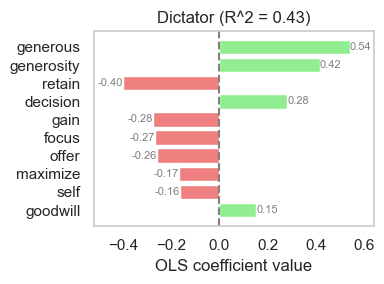

Proposer
R^2 = 0.39, MAE = 5.86
Intercept =  39.78


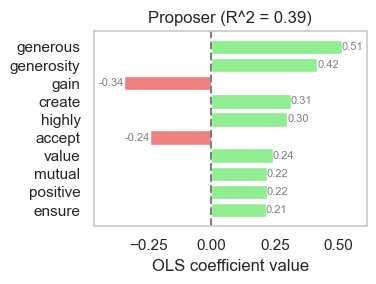

Responder
R^2 = 0.45, MAE = 7.80
Intercept =  31.17


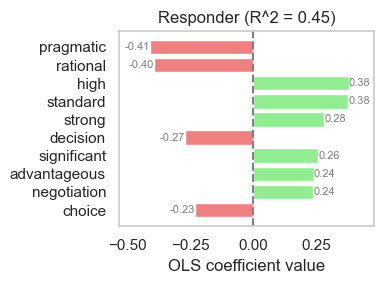

Investor
R^2 = 0.64, MAE = 11.05
Intercept =  50.19


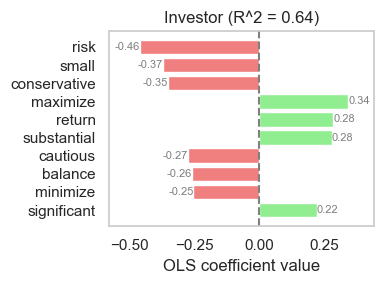

Banker
R^2 = 0.51, MAE = 6.35
Intercept =  76.96


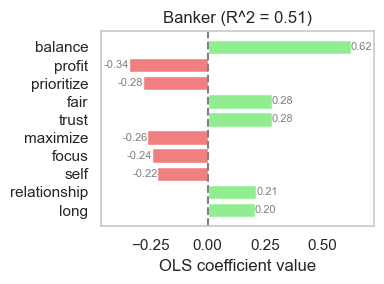

Public Goods
R^2 = 0.63, MAE = 1.82
Intercept =  5.93


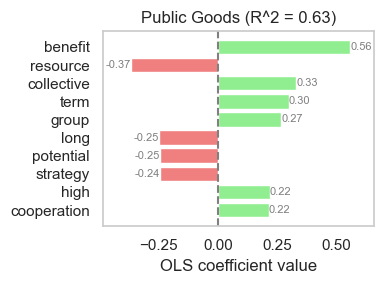

Bomb
R^2 = 0.67, MAE = 8.01
Intercept =  42.27


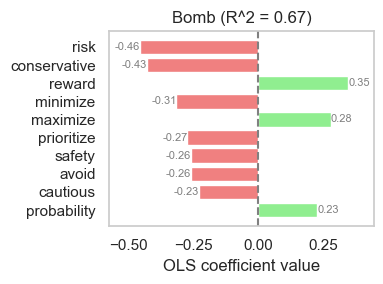

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

for game in ['Dictator', 'Proposer', 'Responder', 'Investor', 'Banker', 'Public Goods', 'Bomb']:
    keywords = game2keywords[game]
    df_game = df[df['game'] == game]
    one_hot_matrix = np.zeros((len(df_game), len(keywords)))
    for i, (_, row) in enumerate(df_game.iterrows()):
        for j, keyword in enumerate(keywords):
            if keyword in row['processed_prompt']:
                one_hot_matrix[i, j] = 1
    
    y = df_game['choices'].apply(eval).apply(np.mean).values
    X = one_hot_matrix

    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    print(game)
    print(f'R^2 = {r2_score(y, y_pred):.2f}, MAE = {mean_absolute_error(y, y_pred):.2f}')
    print(f'Intercept = {reg.intercept_: .2f}')

    coef_abs = np.abs(reg.coef_)
    sorted_indices = np.argsort(coef_abs)[::-1]
    # for i in sorted_indices:
    #     print(f'{keywords[i]}\t{reg.coef_[i]:.2f}')

    # make a plot of the top 10 keywords
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(4, 3))
    top_n = 10
    top_indices = sorted_indices[:top_n]
    top_keywords = [keywords[i] for i in top_indices]
    top_coefs = [reg.coef_[i] for i in top_indices]
    top_coefs = np.array(top_coefs)
    top_coefs = top_coefs / np.linalg.norm(top_coefs)
    plt.barh(top_keywords, top_coefs, color=['lightgreen' if x > 0 else 'lightcoral' for x in top_coefs])
    plt.xlabel('OLS coefficient value')
    plt.title(f'{game} (R^2 = {r2_score(y, y_pred):.2f})')
    plt.axvline(0, color='grey', linestyle='--')
    plt.grid(False)
    plt.xlim(min(top_coefs) - 0.12, max(top_coefs) + 0.1)
    plt.gca().invert_yaxis()
    for i, v in enumerate(top_coefs):
        if v > 0:
            plt.text(v, i, f'{v:.2f}', color='grey', va='center', ha='left', fontsize=8)
        else:
            plt.text(v, i, f'{v:.2f}', color='grey', va='center', ha='right', fontsize=8)
    plt.tight_layout()
    # plt.savefig(f'plots/{game}_keywords.pdf', bbox_inches='tight')
    plt.show()

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error

for game in ['Dictator', 'Proposer', 'Responder', 'Investor', 'Banker', 'Public Goods', 'Bomb']:
    keywords = game2keywords[game]
    df_game = df[df['game'] == game]
    one_hot_matrix = np.zeros((len(df_game), len(keywords)))
    for i, (_, row) in enumerate(df_game.iterrows()):
        for j, keyword in enumerate(keywords):
            if keyword in row['processed_prompt']:
                one_hot_matrix[i, j] = 1
    
    y = df_game['choices'].apply(eval).apply(np.mean).values
    X = one_hot_matrix

    reg = LinearRegression().fit(X, y)
    # reg = Lasso(alpha=.3, max_iter=10000).fit(X, y)
    y_pred = reg.predict(X)
    print(game)
    print(f'R^2 = {r2_score(y, y_pred):.2f}, MAE = {mean_absolute_error(y, y_pred):.2f}')
    print(f'Intercept = {reg.intercept_: .2f}')

    coef_abs = np.abs(reg.coef_)
    sorted_indices = np.argsort(coef_abs)[::-1]
    for i in sorted_indices:
        print(f'{keywords[i]}\t{reg.coef_[i]:.2f}')

Dictator
R^2 = 0.43, MAE = 9.35
Intercept =  41.55
generous	12.05
generosity	9.28
retain	-8.95
decision	6.26
gain	-6.13
focus	-6.00
offer	-5.75
maximize	-3.71
self	-3.65
goodwill	3.37
positive	2.83
advantage	-2.56
party	2.42
create	2.28
optimize	-2.04
resource	-1.93
share	1.88
benefit	1.72
strategic	-1.69
scenario	-1.50
maintain	-1.38
prioritize	-1.25
balance	-1.19
favor	-1.15
balanced	1.07
personal	-1.05
choice	0.85
fairness	0.83
equitable	0.81
fair	-0.80
seek	-0.75
approach	-0.68
thoughtful	0.66
consider	0.65
make	-0.61
reasonable	-0.47
reflect	0.39
ensure	-0.36
slightly	-0.34
involve	-0.32
aim	-0.28
achieve	-0.26
value	-0.25
foster	-0.19
understand	0.15
maker	0.13
outcome	0.10
strive	-0.09
sense	-0.05
considerate	0.02
Proposer
R^2 = 0.39, MAE = 5.86
Intercept =  39.78
generous	5.57
generosity	4.53
gain	-3.74
create	3.40
highly	3.25
accept	-2.64
value	2.62
mutual	2.37
positive	2.37
ensure	2.33
party	2.29
maximize	-2.14
player	1.95
balance	-1.93
strategic	-1.75
acceptance	1.39
achieve

## PCA

k max: 2


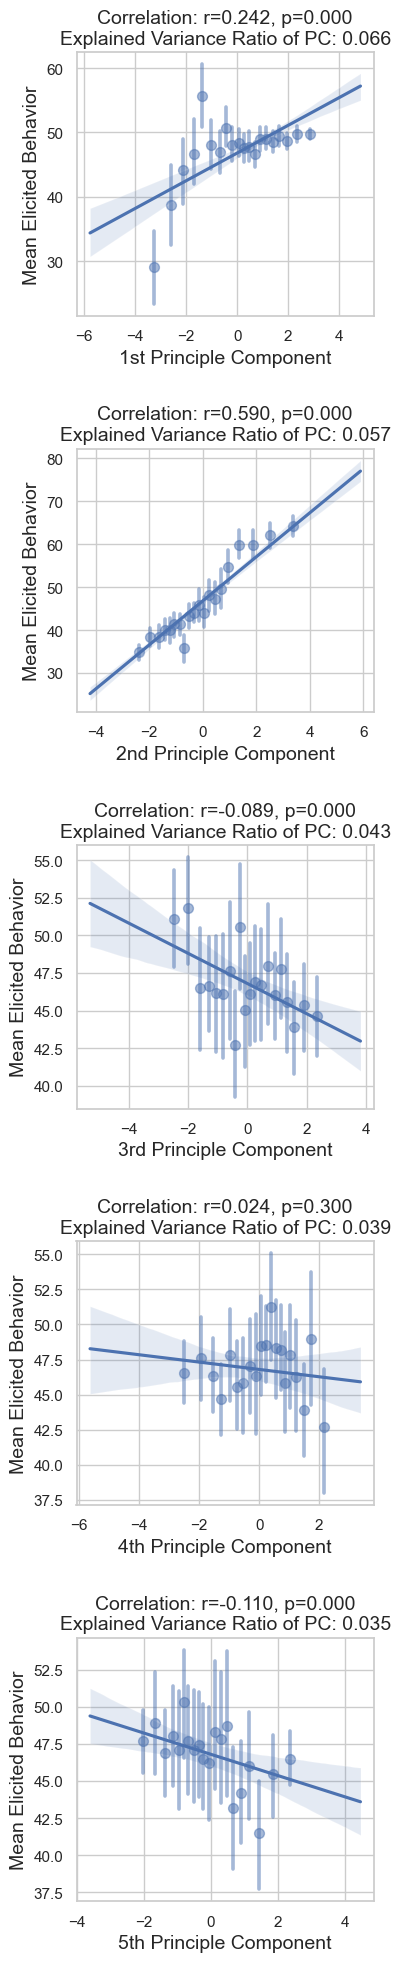

k max: 2


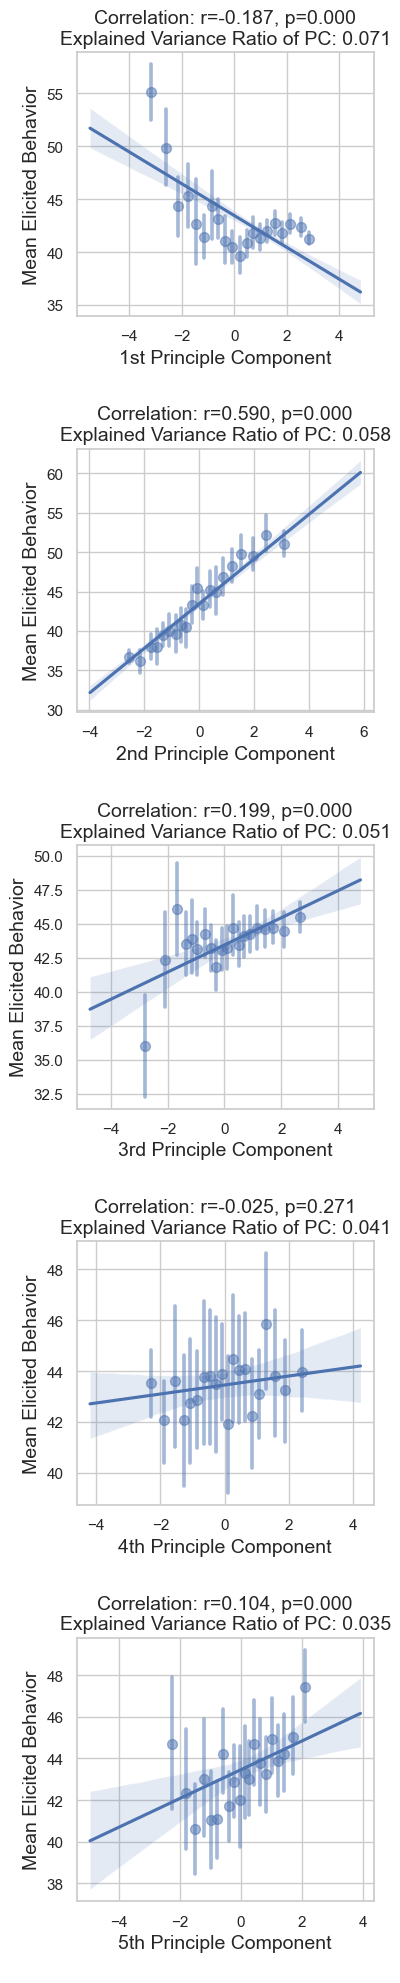

k max: 1


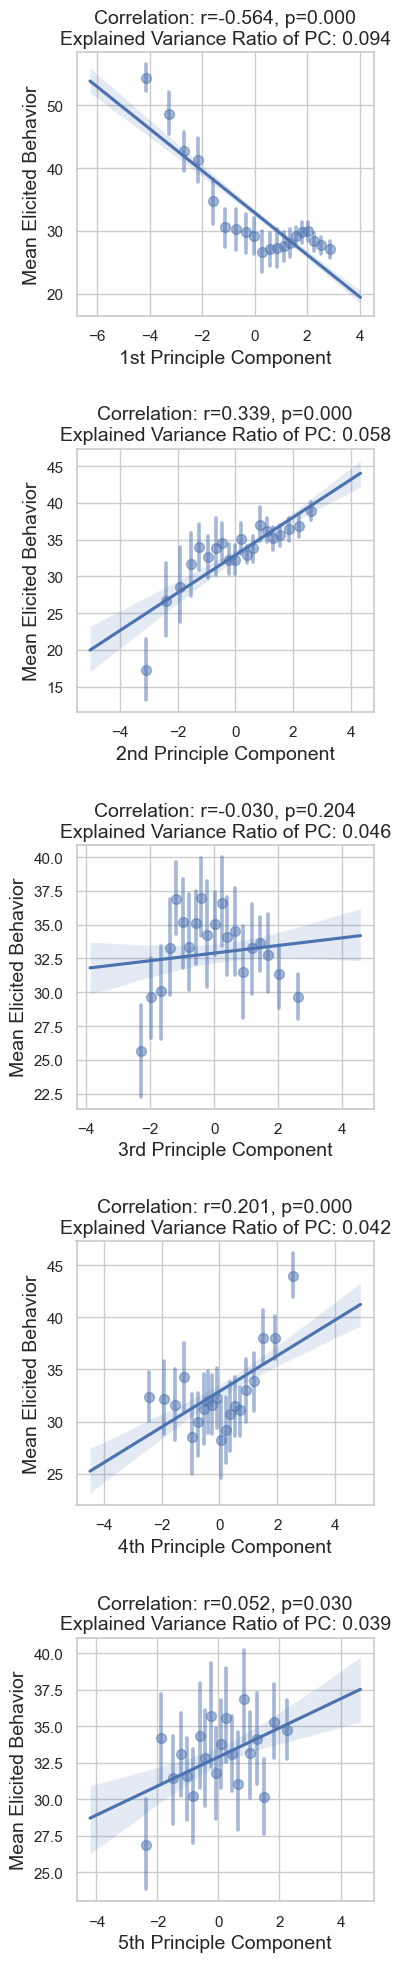

k max: 2


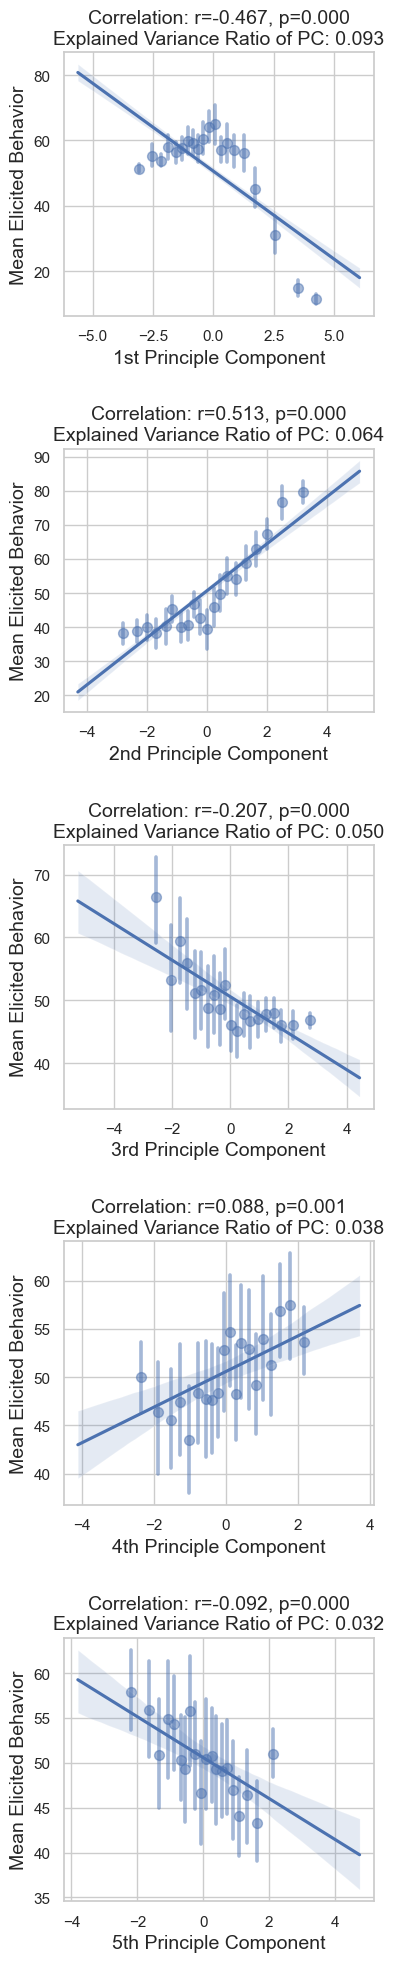

k max: 1


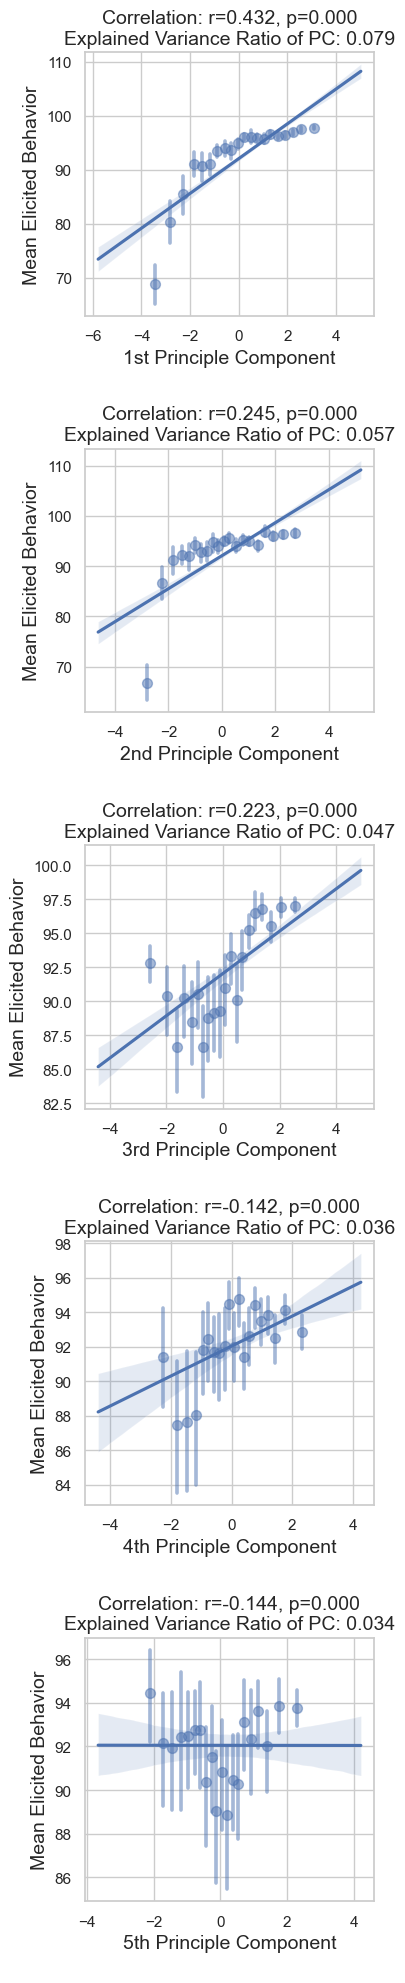

k max: 2


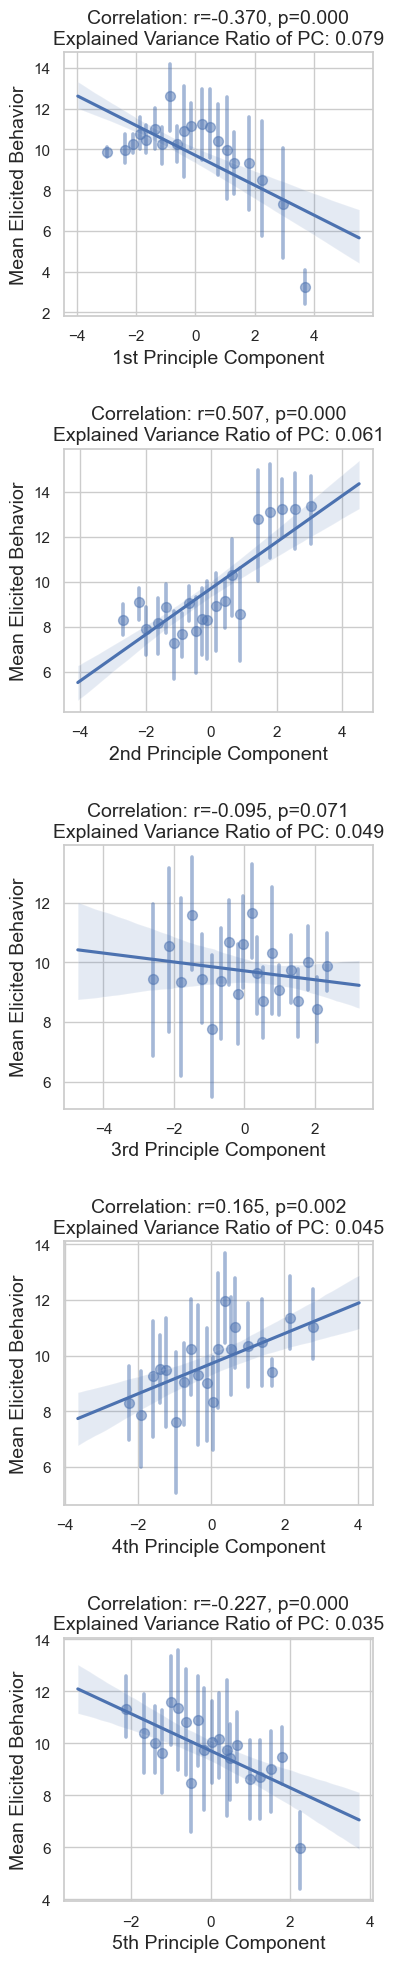

k max: 1


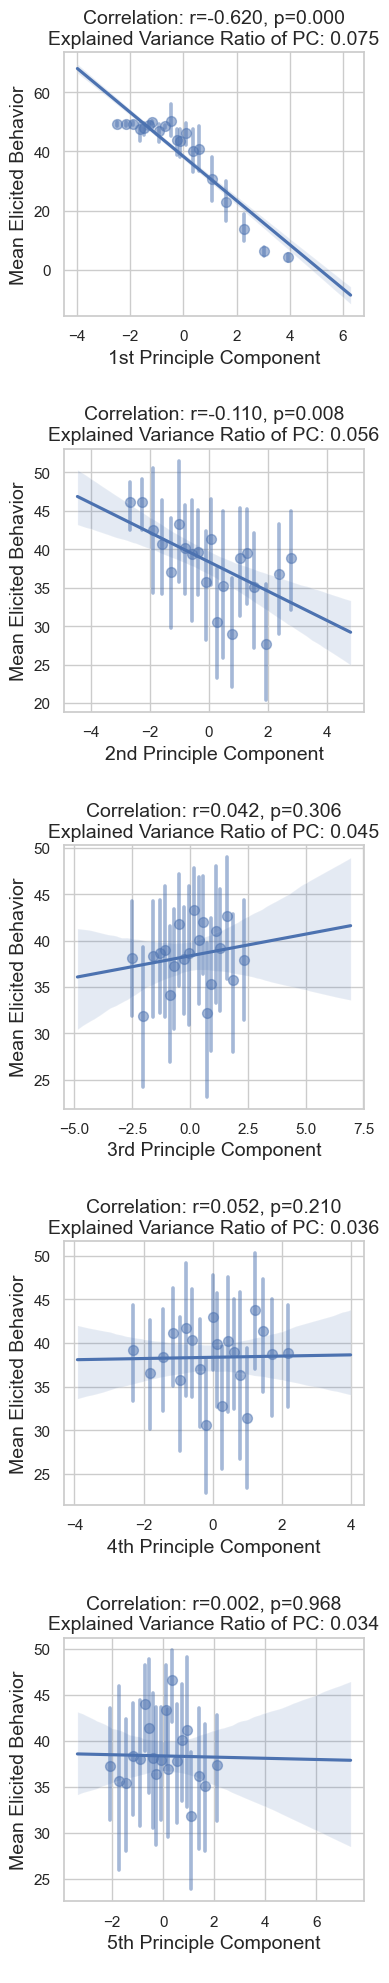

In [9]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to calculate PCA and plot correlation
def plot_pca_choice_correlation(game, df, K=5, corr_func=spearmanr):
    # Filter data for the specific game
    df_game = df[df['game'] == game]
    choices = df_game['choices'].apply(eval).apply(np.mean).values
    
    keywords = game2keywords[game]
    one_hot_matrix = np.zeros((len(df_game), len(keywords)))
    for i, (_, row) in enumerate(df_game.iterrows()):
        for j, keyword in enumerate(keywords):
            if keyword in row['processed_prompt']:
                one_hot_matrix[i, j] = 1
    
    X_ = one_hot_matrix
    X_ = (X_ - X_.mean(axis=0)) / X_.std(axis=0)
    
    pca = PCA(n_components=min(X_.shape[1], X_.shape[0]))
    pca_values = pca.fit_transform(X_)
    pca_vars = pca.explained_variance_ratio_

    correlations = [corr_func(pca_values[:, k], choices)[0] for k in range(pca_values.shape[1])]
    k_max = np.argmax(np.abs(correlations))
    print('k max:', k_max+1)

    # fig, axes = plt.subplots(1, K, figsize=(3.5*(K), 3.5))
    fig, axes = plt.subplots(K, 1, figsize=(4, 4*K))
    # fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))

    def plot_pca_component(k, ax=None):
        if ax is None: ax = axes[k]
        correlation, p_value = corr_func(pca_values[:, k], choices)
        sns.regplot(x=pca_values[:, k], y=choices, scatter_kws={'alpha': 0.5}, ax=ax, x_bins=20)
        # ax.set_ylim(min(choices), max(choices))
        suffix = 'st' if k == 0 else 'nd' if k == 1 else 'rd' if k == 2 else 'th'
        ax.set_xlabel(f'{k+1}{suffix} Principle Component\n', fontsize=14)
        ax.set_ylabel('Mean Elicited Behavior', fontsize=14)
        ax.set_title(f'Correlation: r={correlation:.3f}, p={p_value:.3f}\nExplained Variance Ratio of PC: {pca_vars[k]:.3f}', fontsize=14)

        # find the features in the PCA component
        # coef_abs = np.abs(pca.components_[k])
        # sorted_indices = np.argsort(coef_abs)[::-1]
        # print(f'{k+1}th PC:', end='\t')
        # for i in sorted_indices:
        #     print(f'{keywords[i]} ({pca.components_[k][i]:.2f})', end=', ')
        # print()

    # plot_pca_component(k_max, ax=ax)
    for k in range(K):
        plot_pca_component(k)
    
    # plt.suptitle(f'{game}', fontsize=12)
    plt.tight_layout()
    # plt.savefig(f'plots/pca-first-{game}.pdf', bbox_inches='tight')
    # plt.savefig(f'plots/pca-five-{game}.pdf', bbox_inches='tight')
    plt.show()

    # print the loading vectors as a table, each row is a keyword, each column is a PCA component
    pca_loadings = pd.DataFrame(pca.components_.T, index=keywords, columns=[f'PC{k+1}' for k in range(pca_values.shape[1])])
    # pca_loadings = pca_loadings.sort_values(by=f'PC{k_max+1}', ascending=False)
    # print(pca_loadings.iloc[:, :K])
    pca_loadings.iloc[:, :K].to_csv(f'records/pca_loadings_{game}.csv', index=True)

# Plot for each game
for game in df['game'].unique():
    plot_pca_choice_correlation(game, df)

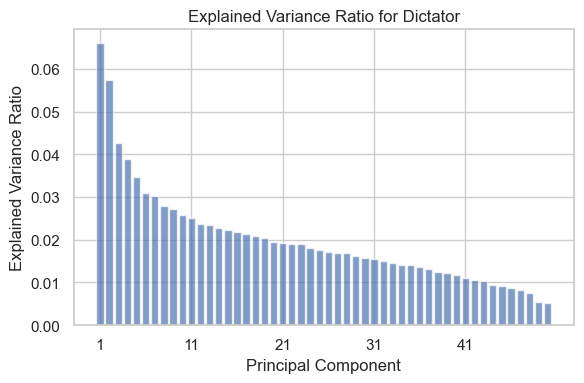

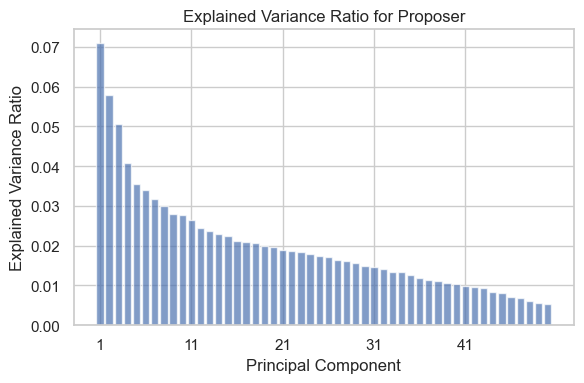

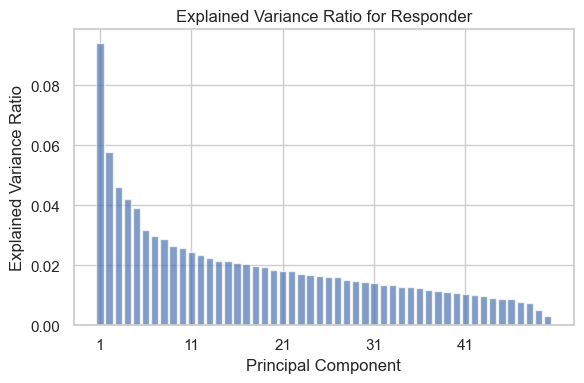

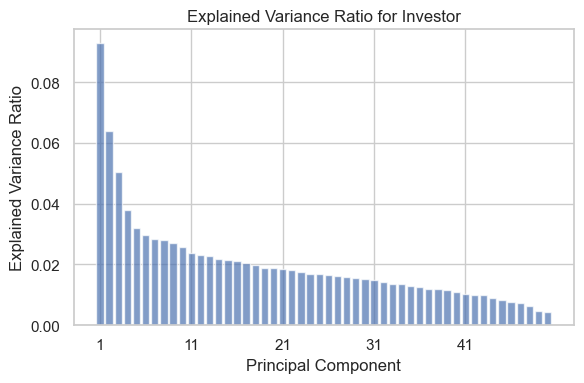

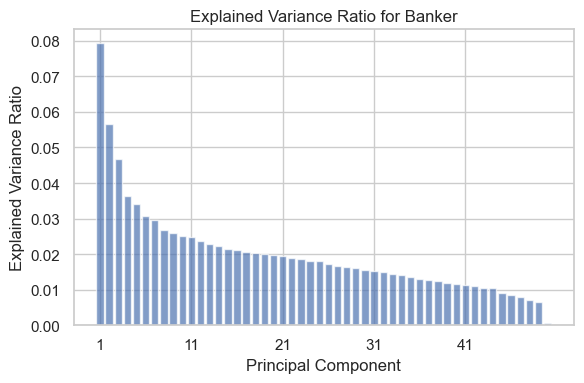

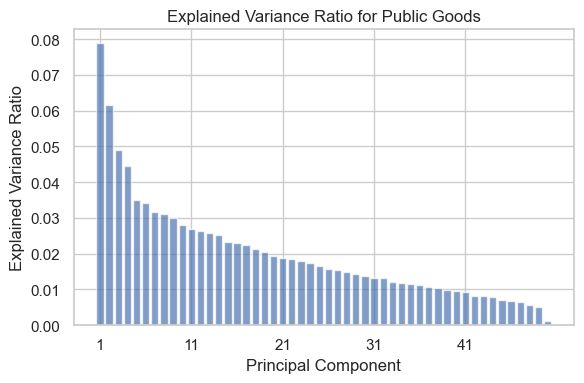

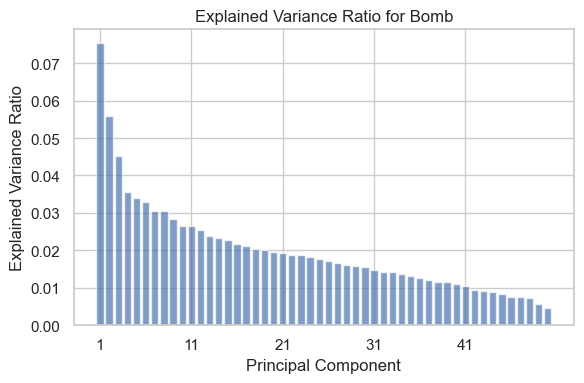

In [10]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to calculate PCA and plot correlation
def plot_pca_choice_correlation(game, df, K=5, corr_func=spearmanr):
    # Filter data for the specific game
    df_game = df[df['game'] == game]
    choices = df_game['choices'].apply(eval).apply(np.mean).values
    
    keywords = game2keywords[game]
    one_hot_matrix = np.zeros((len(df_game), len(keywords)))
    for i, (_, row) in enumerate(df_game.iterrows()):
        for j, keyword in enumerate(keywords):
            if keyword in row['processed_prompt']:
                one_hot_matrix[i, j] = 1
    
    X_ = one_hot_matrix
    X_ = (X_ - X_.mean(axis=0)) / X_.std(axis=0)
    
    pca = PCA(n_components=min(X_.shape[1], X_.shape[0]))
    pca_values = pca.fit_transform(X_)
    pca_vars = pca.explained_variance_ratio_

    # plot the explained variance ratio
    plt.figure(figsize=(6, 4))
    plt.bar(range(1, len(pca_vars) + 1), pca_vars, alpha=0.7)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title(f'Explained Variance Ratio for {game}')
    plt.xticks(range(1, len(pca_vars) + 1, 10))
    # plt.axhline(y=0.01, color='r', linestyle='--', label='1% Threshold')
    # plt.legend()
    plt.tight_layout()
    # plt.savefig(f'plots/pca-explained-variance-{game}.pdf', bbox_inches='tight')
    plt.show()

    
# Plot for each game
for game in df['game'].unique():
    plot_pca_choice_correlation(game, df)